# **Feature Engineering**

Predicting housing Prices: Kaggle competition dataset

In [227]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error as MSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder 
from sklearn.feature_selection import RFE, RFECV, SelectFromModel 
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
#load cleaned dataset
df = pd.read_csv("cleaned_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
numeric = df.select_dtypes(include = "number")

features = numeric.columns[: 36]
correlation = numeric[features].corrwith(numeric["SalePrice"])

print(correlation[(correlation >= 0.5) | (correlation <= -0.5)])

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual       0.682639
BsmtQual        0.585207
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual     0.659600
TotRmsAbvGrd    0.533723
FireplaceQu     0.520438
dtype: float64


## Simple Models to Improve

In [6]:
#Random forest and xgboost
rf = RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 4)
xg_boost = XGBRegressor(n_estimators = 500, learning_rate = 0.02, random_state =1, n_jobs = 4)

In [7]:
df1 = df.copy()

In [8]:
features = ["OverallQual", "YearBuilt", "YearRemodAdd", "ExterQual", "BsmtQual", "TotalBsmtSF",
            "1stFlrSF", "GrLivArea", "FullBath", "KitchenQual", "TotRmsAbvGrd", "FireplaceQu", "OverallCond"]

y = df1["SalePrice"]
X = df1[features]

In [9]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [10]:
#define a function to evaluate models without cross validation
def model_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    model_score = mean_absolute_error(y_test, predictions)
    return model_score

In [11]:
# Random forest
model_eval(rf, X_train, X_test, y_train, y_test)

18640.385702968037

In [12]:
# xgboost
model_eval(xg_boost, X_train, X_test, y_train, y_test)

18753.85582994435

## Creating New Features

I have created new features to further improve the model. Features to create: age of the house at the time it was sold, if it was remodelled or not, total space in square meters, total number of bathrooms, average price per square foot in each neighborhood, overall quality score (10) location value 

### Create new features

In [16]:
#age of the house at the time of selling
df["age"] = df["YrSold"] - df["YearBuilt"]

#years since renovation
df["age_afterRemodel"] = df["YrSold"] - df["YearRemodAdd"]

# binary to indicate wheter the house was renovated before selling or not
df["is_renovated"] = np.nan
for row in df:
    df.loc[df['YearRemodAdd'] != df["YearBuilt"], "is_renovated"] = 1
    df.loc[df["YearRemodAdd"] == df["YearBuilt"], "is_renovated"] = 0

#Total area of the house
df["total_area"] = df["GrLivArea"] + df["GarageArea"] + df["TotalBsmtSF"]

#total bathrooms
df["total_bathrooms"] = df["FullBath"] + df["HalfBath"] * 0.5 + df["BsmtFullBath"] + df["BsmtHalfBath"] * 0.5

#### Price features

In [18]:
# price per square foot
df["price_sqft"] = df["SalePrice"] / df["total_area"] #only used to calculate avg price/sqft in each neighborhood

#neighborhood value. average price of houses in each neighborhood
df["nbd_price_sqf"] = df.groupby("Neighborhood")["price_sqft"].transform("mean")

df["nbd_avg_price"] = df.groupby("Neighborhood")["SalePrice"].transform("mean")

df["SubClass_avg_price"] = df.groupby("MSSubClass")["price_sqft"].transform("mean")

df["Zoning_avg_price"] = df.groupby("MSZoning")["price_sqft"].transform("mean")

df["yearbuilt_avg_price"] = df.groupby("YearBuilt")["SalePrice"].transform("mean")
df["age_avg_price"] = df.groupby("age")["SalePrice"].transform("mean")
df["age_afterRemodel_price"] = df.groupby("age_afterRemodel")["SalePrice"].transform("mean")

df["rooms_avg_price"] = df.groupby("TotRmsAbvGrd")["SalePrice"].transform("mean")

df["bldgtype_avg_price"] = df.groupby("BldgType")["SalePrice"].transform("mean")

df["overalcond_avg_price"] = df.groupby("OverallCond")["SalePrice"].transform("mean")

In [19]:
df.to_csv("extended_df.csv", index = False)

In [20]:
df.to_csv("extended_data.csv", index = False)

### Add polynomial features / interaction terms

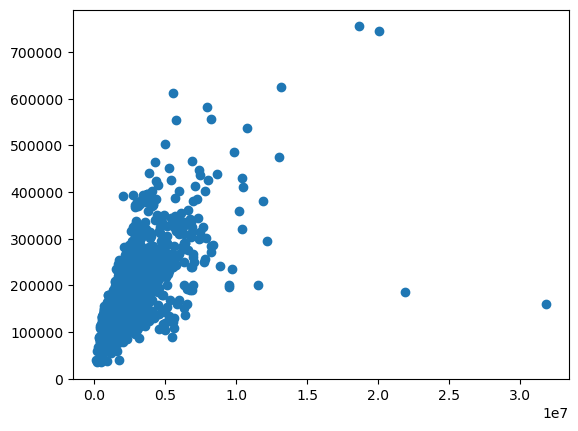

In [22]:
plt.scatter(df['GrLivArea']**2, df['SalePrice'])

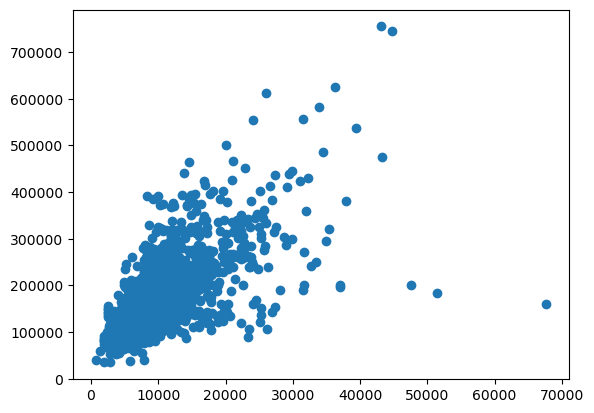

In [23]:
plt.scatter(df["TotRmsAbvGrd"] * df["GrLivArea"], df["SalePrice"])

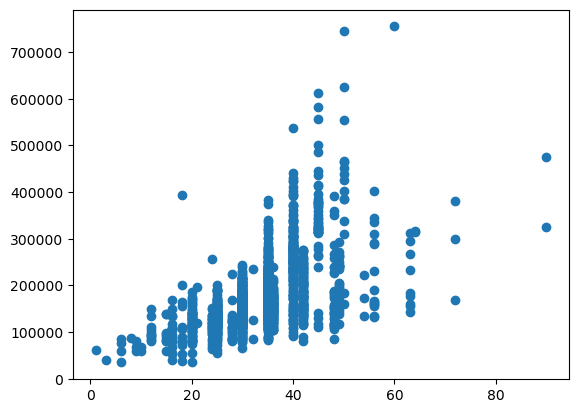

In [24]:
plt.scatter(df["OverallCond"] * df["OverallQual"], df["SalePrice"])

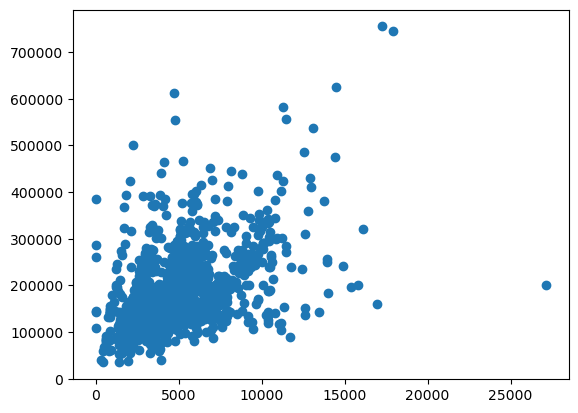

In [25]:
plt.scatter(df["GrLivArea"] * df["BedroomAbvGr"], df["SalePrice"])

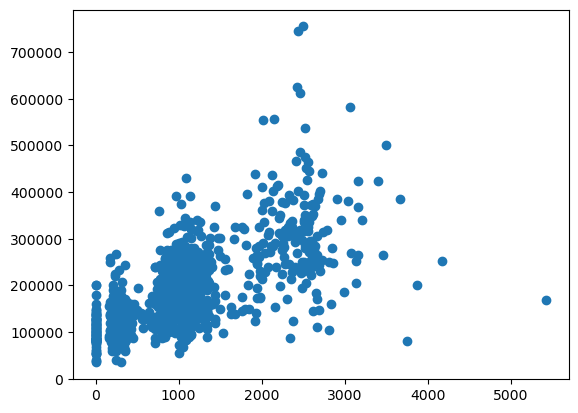

In [26]:
plt.scatter(df["GarageCars"] * df["GarageArea"], df["SalePrice"])

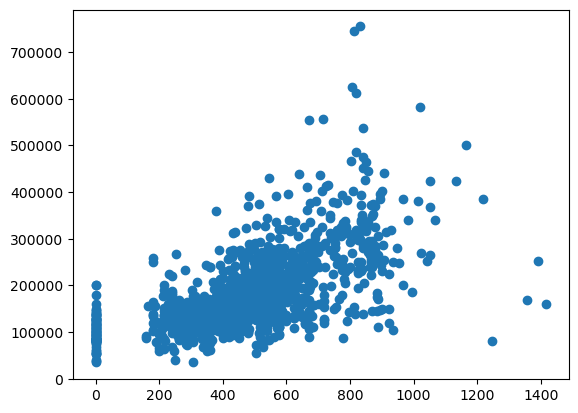

In [27]:
plt.scatter(df["GarageArea"], df["SalePrice"])

## Preprocessing 

In [29]:
features = df.drop(["SalePrice", "price_sqft", "Id"], axis = 1)
y = df["SalePrice"]

num_cols = features.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

In [30]:
# Preprocessing for numeric features
num_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
cat_processor = OneHotEncoder(handle_unknown ='ignore', sparse_output=False)

In [31]:
# Combined preprocessing
preprocessor = ColumnTransformer(transformers = [
    ('num', num_pipeline, num_cols),
    ('cat', cat_processor, cat_cols)
])

#### Selecting features with LassoCV and Recursive Feature Elimination

In [33]:
# lassocv pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, max_iter = 10000))
])

model_pipeline.fit(features, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType...
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('lasso', LassoCV(cv=5, max_iter=10000))])

In [34]:
#Get the lasso model inside the pipeline
lasso = model_pipeline.named_steps['lasso']

# Step 2: Get the preprocessed feature names
# For this, grab the 'preprocessor' first
preprocessor = model_pipeline.named_steps['preprocessor']

# Get feature names for numerical columns
num_features = preprocessor.named_transformers_['num'].named_steps['poly'].get_feature_names_out(input_features=num_cols)

# Get feature names for categorical columns
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=cat_cols)

# Combine them
all_features = np.concatenate([num_features, cat_features])

# Step 3: Match coefficients to features
coefs = lasso.coef_

# Step 4: Select features with nonzero coefficients
selected_features = all_features[coefs != 0]

print("The total number of selected features is:", len(selected_features))
print(selected_features)

The total number of selected features is: 231
['nbd_avg_price' 'Zoning_avg_price' 'age_afterRemodel_price'
 'MSSubClass LotArea' 'MSSubClass GarageCars' 'MSSubClass WoodDeckSF'
 'MSSubClass EnclosedPorch' 'MSSubClass 3SsnPorch'
 'LotFrontage BsmtFinType1' 'LotFrontage BsmtFinSF2'
 'LotFrontage HalfBath' 'LotFrontage WoodDeckSF'
 'LotFrontage is_renovated' 'LotFrontage total_bathrooms'
 'LotFrontage age_afterRemodel_price' 'LotArea^2' 'LotArea BsmtFinType2'
 'LotArea HalfBath' 'LotArea OpenPorchSF' 'LotArea nbd_avg_price'
 'LotArea age_avg_price' 'OverallQual^2' 'OverallQual BsmtFullBath'
 'OverallQual KitchenQual' 'OverallQual Fireplaces'
 'OverallQual total_bathrooms' 'OverallQual yearbuilt_avg_price'
 'OverallCond BsmtExposure' 'OverallCond BedroomAbvGr'
 'OverallCond GarageQual' 'OverallCond EnclosedPorch'
 'OverallCond 3SsnPorch' 'OverallCond ScreenPorch'
 'OverallCond nbd_price_sqf' 'MasVnrArea BsmtUnfSF' 'MasVnrArea 2ndFlrSF'
 'MasVnrArea BsmtFullBath' 'MasVnrArea BsmtHalfBath'
 

In [35]:
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefs
})

# Step 5: Filter only nonzero coefficients
coef_df = coef_df[coef_df['Coefficient'] != 0]

# Step 6 (optional): Sort by absolute size of coefficient
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print(coef_df[:50])

                                Feature   Coefficient
1381            GrLivArea nbd_avg_price  28008.249871
1120          TotalBsmtSF nbd_avg_price  15357.661755
931   BsmtFinSF1 age_afterRemodel_price  13047.329075
2165                    nbd_avg_price^2 -11886.909115
538                   MasVnrArea PoolQC  -9533.179498
248               LotArea nbd_avg_price   8246.112885
1925          OpenPorchSF nbd_avg_price   8048.294129
2310                Exterior1st_BrkFace   7003.453820
1620             KitchenQual GarageCars   6962.404481
911              BsmtFinSF1 OpenPorchSF  -6534.849085
1386   GrLivArea age_afterRemodel_price   5802.161941
548            MasVnrArea nbd_avg_price   5611.737947
370           OverallCond nbd_price_sqf   5236.682334
233                 LotArea OpenPorchSF  -5178.891807
2366                     Functional_Typ   5118.199580
313     OverallQual yearbuilt_avg_price   4904.811922
287              OverallQual Fireplaces   4892.392879
2400              SaleCondit

In [36]:
print(coef_df[50:100])

                                  Feature  Coefficient
2189                yearbuilt_avg_price^2  2209.461493
1206          CentralAir age_afterRemodel  2133.354812
918                     BsmtFinSF1 MoSold -2111.257621
1406             BsmtFullBath OpenPorchSF  2061.948771
1286                 2ndFlrSF ScreenPorch  2060.292053
101                 MSSubClass GarageCars -2053.744708
518               MasVnrArea BsmtHalfBath  2040.014028
1279                  2ndFlrSF GarageArea  1952.669333
2061                  MoSold is_renovated -1947.362138
2067              MoSold Zoning_avg_price  1925.115592
2106        age_afterRemodel is_renovated -1844.046336
1094             TotalBsmtSF KitchenAbvGr -1799.573461
785              BsmtExposure TotalBsmtSF  1766.597284
863              BsmtFinType1 ScreenPorch -1663.291969
1585             KitchenAbvGr GarageYrBlt -1588.171879
2339                   MasVnrType_BrkFace -1584.524360
961              BsmtFinType2 OpenPorchSF -1577.176923
1525      

In [37]:
print(coef_df[100:150])

                               Feature  Coefficient
826   BsmtExposure yearbuilt_avg_price   993.699157
1621            KitchenQual GarageArea   992.041905
357          OverallCond EnclosedPorch   989.230035
220                   LotArea HalfBath   962.178563
2261               Neighborhood_Timber  -953.556065
1211          CentralAir nbd_avg_price  -946.822682
1294             2ndFlrSF is_renovated   938.206025
1288                   2ndFlrSF PoolQC   912.742581
108               MSSubClass 3SsnPorch   904.305595
1935           EnclosedPorch 3SsnPorch  -887.793037
1913           OpenPorchSF ScreenPorch   886.102456
818      BsmtExposure age_afterRemodel  -884.455320
2397                      SaleType_New   878.036961
1290                   2ndFlrSF MoSold  -858.000152
67                  MSSubClass LotArea  -854.493190
1401           BsmtFullBath GarageCars   820.511337
517            MasVnrArea BsmtFullBath   819.482844
1445          BsmtHalfBath OpenPorchSF   818.092561
804         

### RFE with feature_importances_

In [39]:
# Split your full data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.2, random_state = 42)

In [40]:
# pipeline for RFE
rfe = Pipeline([
    ('preprocess', preprocessor),
    ('rfe', RFE(
        estimator = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1),
        step = 0.2,
        n_features_to_select = 40
    ))
])

rfe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'...
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('rfe',
                 RFE(estimator=RandomForestRegressor(n_jobs=-1,
                                                     random_state=42),
                     n_features_to_select=40, step=0.2))])

In [41]:
y_pred = rfe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))

print(f"Test RMSE: {rmse:.2f}")
print("\n")
print(f"Test mean absolute error: {mae:.2f}")

Test RMSE: 27179.43


Test mean absolute error: 15496.50


In [42]:
#Get feature names after preprocessing
X_transformed = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()

#Access RFE selector and get selected features
rfe_selector = rfe.named_steps['rfe']
selected_features = feature_names[rfe_selector.support_]

# Print selected features
print("Selected features:")
print(selected_features)


Selected features:
['num__LotFrontage yearbuilt_avg_price' 'num__OverallQual GrLivArea'
 'num__OverallQual total_area' 'num__OverallQual nbd_price_sqf'
 'num__OverallQual rooms_avg_price' 'num__OverallCond total_area'
 'num__OverallCond age_avg_price' 'num__ExterQual total_area'
 'num__BsmtQual total_area' 'num__BsmtQual nbd_price_sqf'
 'num__BsmtCond total_area' 'num__BsmtExposure 2ndFlrSF'
 'num__BsmtExposure GrLivArea' 'num__BsmtFinSF1 nbd_avg_price'
 'num__BsmtFinType2 FullBath' 'num__BsmtFinType2 age_avg_price'
 'num__HeatingQC total_area' 'num__CentralAir total_area'
 'num__1stFlrSF age_avg_price' 'num__2ndFlrSF yearbuilt_avg_price'
 'num__GrLivArea nbd_avg_price' 'num__GrLivArea yearbuilt_avg_price'
 'num__GrLivArea age_avg_price' 'num__BsmtFullBath yearbuilt_avg_price'
 'num__KitchenQual total_area' 'num__Fireplaces yearbuilt_avg_price'
 'num__Fireplaces age_afterRemodel_price' 'num__total_area nbd_price_sqf'
 'num__total_area nbd_avg_price' 'num__total_area SubClass_avg_price'

### Now RFECV 

In [76]:
rfecv = Pipeline([
    ('preprocess', preprocessor),
    ('rfe', RFECV(
        estimator = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1),
        step = 0.2,
        min_features_to_select = 30,
        cv = KFold(5),
        scoring = 'neg_root_mean_squared_error',
        n_jobs = -1
    ))
])

rfecv.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'...
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('rfe',
                 RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=RandomForestRegressor(n_jobs=-1,
                                                       random_state=42),
                       min_features_to_select=30, n_jobs=-1,
                       scoring='neg_root_mean_squared_error', step=0.2))])

In [79]:
y_pred = rfecv.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))

print(f"Test RMSE: {rmse:.2f}")
print("\n")
print(f"Test mean absolute error: {mae:.2f}")

Test RMSE: 28555.05


Test mean absolute error: 15862.02


In [81]:
rfecv.named_steps['rfe'].n_features_

1444